# Analytical Approximation for Gravitational Waves #

Main source whose code was used as template for this project:\
Buskirk and Babiuc arxiv.org/pdf/1810.06160, github.com/mbabiuc/MathScripts\
Main author: Dan Hancock, dhancock2@eagles.bridgewater.edu\
Advisor: Deva O'Neil, doneil@bridgewater.edu

In [2]:
from numpy import *
from scipy.misc import derivative
from scipy.special import zeta
from scipy.special import hyp2f1
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.integrate import RK45
from scipy.integrate import solve_ivp
import pandas as pd
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt

To create an analytical model to find the waveform of gravitational waves emitted from a merging binary system of black holes, we use the best known method of calculating gravitational waves, Post-Newtonian (PN) theory. However, since PN theory only applies to weak fields where objects move slowly relative to $c$. This implies that we need to use separate models for the inspiral phase, when the black holes are orbitting eachother, and the merger phase when the black holes begin to merge. For this merger phase, we choose to use the $\textit{generic Implicit Rotating Source, gIRS}$ model, which utilizes an analytical fit of the data to results from numerical relativity.

# **Inspiral Phase Time Evolution**

## Variables and Constants

### Setting Up the Mass Parameters

In this notebook, we model the gravitational waves released by a binary system of equal mass $m_1 = m_2 = 20M_\odot$

In [3]:
m1 = 20; m2 = 20; # Individual Mass Parameters

sf = 100000     #Scale Factor

q = m1/m2;        # Mass Ratio

M = m1 + m2;      # Total Mass

μ = (m1*m2)/M;    # Reduced Mass

η = μ/M;          # Symmetric Mass Ratio

print("η = ",η);   #accuracy check

η =  0.25


### Geometric Units Conversion

For ease of calculations, this notebook uses geometric units where $G = c = 1$ so that the Newtonian gravitational field simplifies to $\Phi = -M/r$

In [4]:
Ms = M*(4.923*10**(-6));# Mass in terms of seconds

Mr = M*(1.476);         # Mass in terms of kilometers

G = c = 1 ;             # Geometric units (G = c)

γ = 0.5772156649;       # Euler's Constant

e = 0;                  # 0 eccentricity, circular orbit

R = 1;                  # distance to observer

i = 0; κ = 0;           # optimal angular orientation is assumed

flow = 10;              # frequency cut-off of 10 Hz

G = 6.673*10**(-11); c = 2.998*10**(8)

Mokg = (1.989*10**(30)); Mos = (4.923*10**(-6)); Mokm = (1.476) #expressing individual units for mass

Ms = M*Mos; Mr = M*Mokm; #writing mass in terms of 2 variables for different units

v0 = ((G*M*Mokg*pi*flow)**(1/3)) #initial velocity of binary

print("v0 = ",v0)       #check this value for accuracy

v0 =  55045513.06174693


The following two functions are used to make the code more concise and easier to understand

In [5]:
#Inputs function, time array, size of time array, and modifiers to the function for addition and multiplication
#Plots a graph and returns the array of the function
def makeGraphable(f,tarray,size,multiply=1,add=0,graph=True,label=''):
    
    fs = [0] * size
    n = 0
    for i in tarray:
        fs[n] = f(i)*multiply + add
        n = n + 1
    if graph == True:
        plt.plot(tarray,fs,label=label)
    return(fs)

#Inputs array, size of array, and modifiers to the array for multiplication and addition
#Returns the array modified by the input parameters
def modifyArray(f,size,multiply=1,add=0):
    n=0
    fs = [0] * size
    for i in f:
        fs[n] = f[n]*multiply + add
        n = n + 1
    return(fs)

### Integration Bounds

Before the model can be implemented, we first have to determine the integration bounds of the PN-parameter $x$. The lower bound is determined based upon the smallest frequency that can currently be measured by experimental instruments. This threshold frequency for the Advanced LIGO detection band is $f_{low} = 10Hz$ due to Earth's seismic activity (Buskirk and Babiuc, 0). Using Kepler's third law, $v_0=GM\omega_{low}^{1/3}$, and conversions between linear and angular frequency, we arrive at the following result:

$$x_{low} = \frac{v_0}{c}^2 = \frac{GM\pi f_{low}}{c^3}^{2/3}$$

The upper bound of integration comes from the last stable orbit of the binary. By determining the radius of this orbit, $r_{ISCO} = 3R_{Sch} = 6\frac{GM}{c^2}$, we can find the velocity, $v_{ISCO} = \sqrt{GM/r_{ISCO}} = \frac{c}{\sqrt{6}}$. From this velocity, we can add a $2^{nd}$ order PN correction to add a dependence on the symmetric mass ratio (Blanchet et al., 105):

$$x_{high} = \frac{1}{6}\bigg{(}1+\frac{7}{18}\eta\bigg{)}$$

Additionally, since we found the velocity of the last stable orbit, we can use Kepler's third law to find the frequency of this orbit:

$$f_{ISCO} = \sqrt{\frac{GM}{\pi^2r_{ISCO}^3}} = \frac{c^3}{6^{3/2}GM\pi}$$

In [6]:
#temporary final integration bound
temp = 100; 

xlow = (pi*M*Mos*flow)**(2/3); #
print("xlow = ", xlow); # check for accuracy

xhigh = (1/6)*(1+((7/18)*η)); #
print("xhigh = ", xhigh); #check for accuracy

xlow =  0.0336997335060572
xhigh =  0.18287037037037038


### First level constant

In Newtonian physics, two gravitationally bound objects will remain locked in orbit of eachother permanently. However, Einstein's equations predict that the system will gradually lose energy in the form of gravitational waves. In this situation predicted by Einstein's equation, the energy release can be modelled using:

$$\frac{dE}{dt} = -\mathcal{F}$$ 

where $E$ is the energy of the binary and $\mathcal{F}$ is the flux of the gravitational waves. Since we wil be working with PN physics, we have to add a correction of order $(\frac{v}{c})^n$ to the Newtonian equation of gravity:

$$\frac{dv}{dt} = -G\frac{M}{r}[1+\frac{1PN}{c^2}+\frac{1.5PN}{c^3}+\frac{2PN}{c^4}+...]$$

Current research in this PN expansion is able to compute up to the $3.5^{th}$ order. Using the PN-parameter $x = \frac{v^2}{c^2}$, the relationship between tangential velocity to angular frequency, $v = \omega r$ and Kepler's third law, $\omega^2r^3 = GM$, we can develop the following relationship between the PN-parameter $x$ and the angular frequency of the binary system $\omega$:

$$x = \frac{v^2}{c^2} = \frac{(GM\omega)^{2/3}}{c^2}$$

Now that we have an equation for $x$, we can find a way to create $x$ as a function of time in order to model the gravitational waves emitted from a binary through its evolution. To do this, we can use the chain rule to rewrite the flux equation:

$$\frac{dx}{dt} = \frac{-\mathcal{F}}{dE/dx}$$

Several known solutions to this differential equation exists, but the one that agrees the most with numerical relativity is the Taylor T4 model (Hinder et al., 10):

$$\dot{x} = \dot{x}_{0PN}x^5+\dot{x}_{1PN}x^6+\dot{x}_{2PN}x^6+\dot{x}_{3PN}x^8+\dot{x}_{HT}$$

While earlier it was mentioned that solutions only exist up to the $3.5^{th}$ order, $\dot{x}_{HT}$ represents the hereditary terms of the system including nonlinear PN terms up to order $6$. These hereditary terms take into consideration the interactions between the gravitational waves and spacetime. By modeling each PN term as a power series we get the final result of the T4 expansion (Huerta et al., 7):

$$M\dot{x}\big\vert^{6PN} = \frac{64}{5}\eta x^5\bigg{(}1+\sum_{k=2}^{12}a_{\frac{k}{2}}x^{\frac{k}{2}}\bigg{)}$$

Solving this differential equation will result in the evolution of the PN parameter $x$.

In [7]:
c0 = 153.8803;               #Tiec et al., arxiv.org/pdf/1609.05933, eq (4.25)

c1 = -55.13;                 #Constants used in PN coefficients

c2 = 588;

c3 = -1144;

### Second Level -> Dependent on Symmetric Mass Ratio

In [8]:
# Buskirk and Babiuc arxiv.org/pdf/1810.06160

#PN coefficients

#coefficient a = 1
a1 = ((-743/336)-11/4*η)

#coefficient a = 1.5
a1p5 = (4*pi)

#coefficient a = 2
a2 = (34103/18144 + 13661/2016*η + 59/18*η**2)

#coefficient a = 2.5
a2p5 = ((-4159*pi)/672 - (189*pi)/8*η)

#coefficient a = 3
def a3(xt): 
    return((16447322263/139708800 - (1712*γ)/105 + (16*pi**2)/3- 856/105*math.log(16*xt) + (-56198689/217728 + (451*pi**2)/48)*η+ 541/896*η**2 - 5605/2592*η**3))

#coefficient a = 3.5
a3p5 = ((-(4415/4032) + 358675/6048*η + 91945/1512*η**2)*pi)

print("a1 = ",a1)
print("a1.5 = ",a1p5)
print("a2 = ",a2)
print("a2.5 = ",a2p5)
print("a3(1) = ",a3(1))
print("a3.5 = ",a3p5)

a1 =  -2.8988095238095237
a1.5 =  12.566370614359172
a2 =  3.778508046737213
a2.5 =  -37.9983111434194
a3(1) =  97.00775780156748
a3.5 =  55.07786425955022


In [9]:
#Huerta et al., arxiv.org/pdf/1609.05933, eq (C1-C5)

#PN coefficients

#Coefficient a4

def a4(xt):
    return((-5*η*c0) - ((97*η**4)/3888) - ((18929389*η**3)/435456) - ((3157*pi**2*η**2)/144) + ((54732199*η**2)/93312) - (47468/315*η*math.log(xt)) -((31495*pi**2*η)/8064) - ((856*γ*η)/315) + ((59292668653*η)/838252800) - ((1712/315*η)*math.log(2)) + ((124741*math.log(xt)/8820)) - ((361*pi**2)/126) + ((124741*γ)/4410) + (3959271176713/25427001600) - ((47385*math.log(3)/1568)) + ((127751*math.log(2)/1470)))
print("a4(1) = ",a4(1));

#Coefficient a4.5
def a4p5(xt):
    return((9731*pi*η**3)/1344 + ((42680611*pi*η**2)/145152) + ((205*pi**3*η)/6) - ((51438847*pi*η)/48384) - (3424/105*pi*math.log(xt)) - ((6848*γ*pi)/105) + ((343801320119*pi)/745113600) - (13696/105*pi*math.log(2)))
print("a4.5(1) = ",a4p5(1))

#Coefficient a5
def a5(xt):
    return(((155*c0*η**2)/12) + ((1195*c0*η)/336) - (6*η*c1) - ((11567*η**5)/62208) + ((51474823*η**4)/1741824) + ((9799*(pi**2)*η**3)/384) -((9007776763*η**3)/11757312) + (216619/189*η**2*math.log(xt)) - ((126809*(pi**2)*η**2)/3024) - ((2354*γ*η**2)/945) + ((1362630004933*η**2)/914457600) - (4708/945*η**2*math.log(2)) + ((53963197*η*math.log(xt))/52920) + ((14555455*pi**2*η)/217728) + ((3090781*γ*η)/26460) - ((847101477593593*η)/228843014400) - ((15795*η*math.log(3))/3136) + (2105111*η*math.log(2)/8820) - (5910592*math.log(xt)/1964655) - ((21512*pi**2)/1701) - ((11821184*γ)/1964655) + (29619150939541789/36248733480960)+ ((616005*math.log(3))/3136) - ((107638990*math.log(2))/392931))
print("a5(1) = ",a5(1))

#Coefficient a5.5
def a5p5(xt):
    return(((-20*pi*η*c0) + ((49187*pi*η**4)/6048) - ((7030123*pi*η**3)/13608) - ((112955*pi**3*η**2)/576) + ((1760705531*pi*η**2)/290304) - (189872/315*pi*η*np.log(xt)) - ((26035*pi**3*η)/16128) - ((3424*γ*pi*η)/315) - ((2437749208561*pi*η)/4470681600) - (6848/315*pi*η*np.log(2)) + ((311233*pi*np.log(xt))/11760) + ((311233*γ*pi)/5880) + ((91347297344213*pi)/81366405120) - (142155/784*pi*np.log(3)) + ((5069891*pi*np.log(2))/17640)))
print("a5.5(1) = ",a5p5(1))

#Coefficient a6, uses zeta function
def a6(xt):
    return((((-535*c0*η**3)/36)) + ((7295*c0*η**2)/336) - ((248065*c0*η)/4536) + ((31*c1*η**2)/2) + ((239*c1*η)/56) - (7*c2*η) - (7*c3*η*math.log(xt)) - (c3*η) - ((155377*η**6)/1679616) - ((152154269*η**5)/10450944) - ((1039145*pi**2*η**4)/62208) + ((76527233921*η**4)/94058496) - ((41026693*η**3*math.log(xt))/17010) + ((55082725*pi**2*η**3)/217728) - ((2033*γ*η**3)/1701) - ((56909847373567*η**3)/7242504192) - ((4066*η**3*math.log(2))/1701) - ((271237829*η**2*math.log(xt))/127008) + ((92455*pi**4*η**2)/1152) - ((4061971769*pi**2*η**2)/870912) - ((21169753*γ*η**2)/317520) +((3840832667727673*η**2)/55477094400) - ((57915*η**2*math.log(3))/12544) - ((2724535*η**2*math.log(2))/21168) - (4387/63*pi**2*η*math.log(xt)) - ((12030840839*η*math.log(xt))/37721376) + ((410*pi**4*η)/9 - 8774/63*γ*pi**2*η) + ((206470485307*pi**2*η)/1005903360) + ((362623282541*γ*η)/94303440) - ((12413297162366594971*η)/271865501107200) + ((3016845*η*math.log(3))/12544) - (17548/63*pi**2*η*math.log(2)) + ((701463800861*η*math.log(2))/94303440) + ((366368*math.log(xt)**2)/11025) + ((2930944*math.log(2)*math.log(xt))/11025) - (13696/315*pi**2*math.log(xt)) + ((1465472*γ*math.log(xt))/11025) - ((155359670313691*math.log(xt))/157329572400) - ((27392*zeta(3))/105) - ((256*pi**4)/45) - ((27392*γ*pi**2)/315) + ((1414520047*pi**2)/2619540) + ((1465472*γ**2)/11025) - ((155359670313691*γ)/78664786200) + (1867705968412371074441833/154211174411374080000) + ((5861888*math.log(2)**2)/11025) - ((37744140625*math.log(5))/260941824) - ((63722699919*math.log(3))/112752640) - (54784/315*pi**2*math.log(2)) + ((5861888*γ*math.log(2))/11025) - ((206962178724547*math.log(2))/78664786200))
print("a6(1) = ",a6(1))

a4(1) =  7.6181852176382066
a4.5(1) =  535.1980682872841
a5(1) =  413.8820891710324
a5.5(1) =  1533.8963676993062
a6(1) =  2082.2302605990744


## Calculating PN Parameter, x

Here, the equation for $\frac{dx}{dt}$ is broken into parts so that each portion can be tested separately

In [10]:
# Buskirk and Babiuc arxiv.org/pdf/1810.06160 Eq. 6

#First half of PN sum
def xt3p5(xt):
    return(64/5*η*xt**5*(1 + (a1*xt + a1p5*xt**1.5 + a2*xt**2 + a2p5*xt**2.5 + a3(xt)*xt**3 + a3p5*xt**3.5))) 
print("xt3.5(1) = ", xt3p5(1))

#Second half of PM sum
def xt4to6(xt):
    return(64/5*η*xt**5*(a4(xt)*xt**4 + a4p5(xt)*xt**4.5 + a5(xt)*xt**5 + a5p5(xt)*xt**5.5 + a6(xt)*xt**6)) 
print("xt4to6(1) = ", xt4to6(1))

#Total PM sum -- equal to Ms*dx/dt
def xt6(xt):
    return(xt3p5(xt) + xt4to6(xt)) 
print("xt6(1) = ",xt6(1))

#Final right hand side of DE, converted into geom. units
def dxdt(xt):   
    return(xt6(xt)/Ms) 
print("dxdt(10) = ",dxdt(10)) #time derivative of PN parameter-x. Now the DE is ready to be solved in order to find x

xt3.5(1) =  411.30681617595246
xt4to6(1) =  14633.039907117876
xt6(1) =  15044.34672329383
dxdt(10) =  5.785074655329786e+18


## Solve DE for x in Initial Timescale

Here, the differential equation is solved on a timescale that goes from 0 to $t_Fin$ with a set number of time iterations to take data at. scipy.integrate.odeint is used because it had more accurate results when compared to the RK45 method from scipy.integrate.solve_ivp and scipy.integrate.RK45. $t_Fin$ is determined by finding the stiff time, which is done by guessing arbitrary final values for the DE until it no longer gives an error, and then subtracting the time it takes for the binary black holes to go from the innermost stable circular orbit to the light ring (Buskirk and Babiuc, 10).

In [11]:
tStiff = 11.9248
tf = 2*Ms
tFin = tStiff-tf
ti=tFin-1

Text(0.5, 1.0, 'PN-Parameter Evolution')

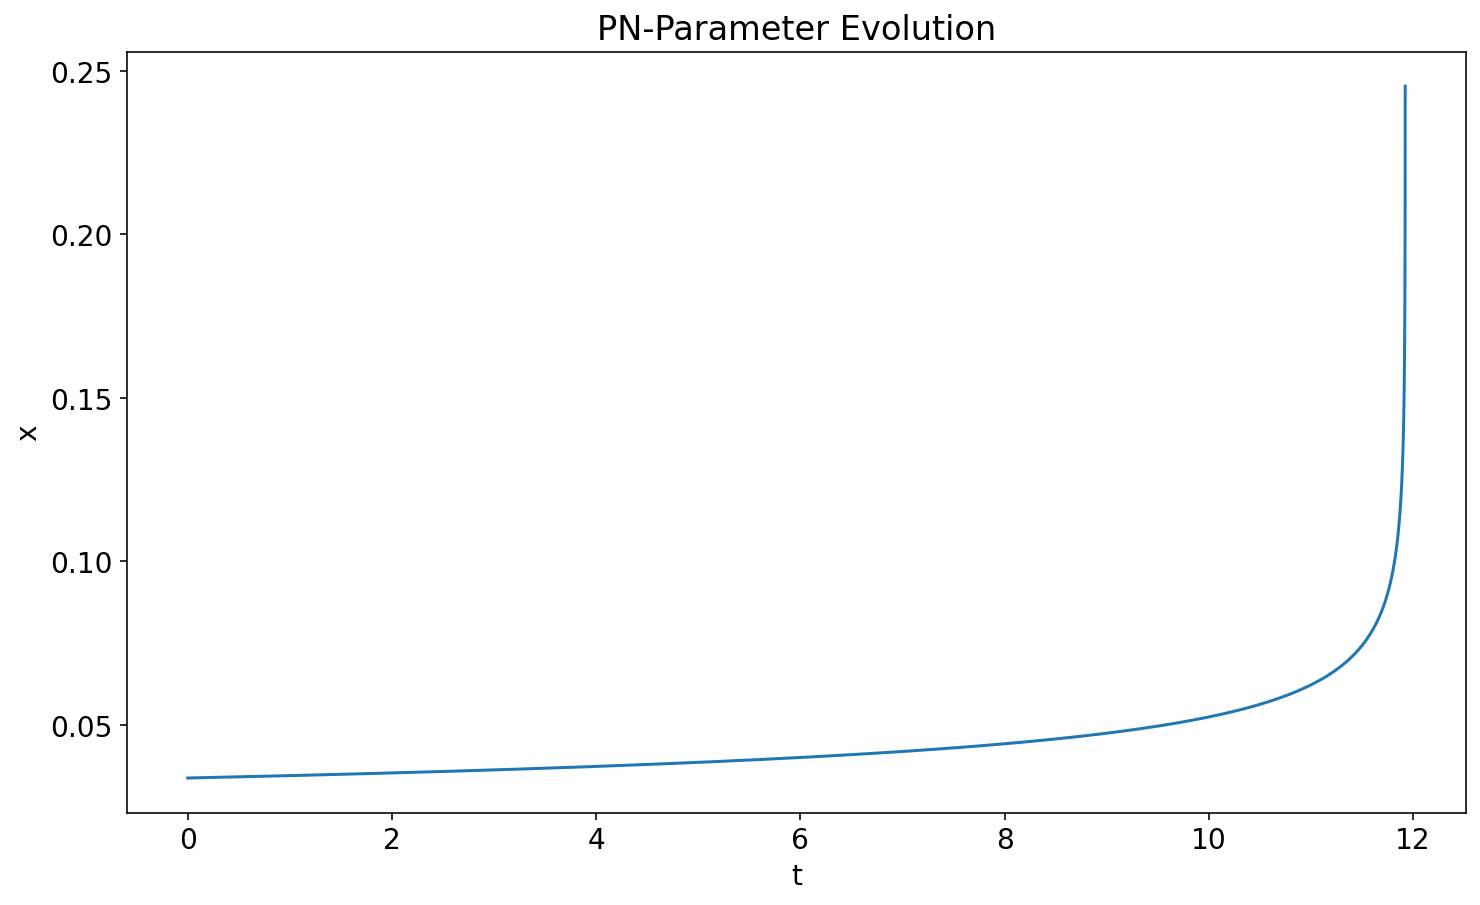

In [12]:
#Function of x and t to use for solving the DE
def dx_dt(x, t):
       return(dxdt(x))
ts = np.linspace(0,tFin,sf)
x0 = xlow  # the initial condition
xs = odeint(dx_dt, x0, ts,) #Solves for x                               #Read about other ways to calculate this and compare with Mathematica
xs = np.array(xs).flatten()# Plot the numerical solution
plt.rcParams.update({'font.size': 14})  # increase the font size

plt.xlabel("t")
plt.ylabel("x")
plt.plot(ts, xs);
plt.title('PN-Parameter Evolution')

## Final Integration Time

Now that the DE is solved and we have found the evolution of the PN parameter $x$, we need to take the results from the array created by odeint and include only the data in the last second before the DE becomes stiff so that we can observe the results with more clarity.

In [13]:
#Since the initial DE was solved from t = 0 to t = 12
#we need to find how many iterations happened in the time we are concerned about
#This allows us to make graphs and data more accurate

IntegrationSteps = int(sf/tFin)

IntegrationSteps = IntegrationSteps + 1
print("IntegrationSteps = ",IntegrationSteps)
StartIndex = sf - IntegrationSteps

IntegrationSteps =  8387


Since python is unable to model arrays as continuous functions of a variable, we need to create a function that will translate the array created by odeint into a function that can be used mathematically.

In [14]:

tsadjusted = ts[StartIndex:]
#Creates new arrays of x and t data by mapping the data found using ODEint onto the specific time interval that we want
step = 0
l = 0
tscaled = [0] * IntegrationSteps
xscaled = [0] * IntegrationSteps
for x in ts:
    if x > tFin:
        break
    if x > ti:
        xscaled[step] = xs[l]
        tscaled[step] = x
        step = step + 1
    l = l + 1
    
#This algorythm takes the data from the x and t arrays and creates a function that maps specific x's to specific t's
def xins(t):                         
    j = 0                                
    for i in xscaled:
        if tscaled[j] == t:
            return(xscaled[j])
        if tscaled[j] > t:
            if j == 0:
                return(xscaled[j])
            return(xscaled[j-1])
        j = j + 1
        if t > tscaled[IntegrationSteps - 1]:
            return(xscaled[IntegrationSteps - 1])
    return(1)

## Orbital Frequency Evolution

After finding the PN-parameter, $x$, we can now find the evolution of the orbital frequency, $\omega$, by using Kepler's third law:

$$x = \frac{(GM\omega)^{2/3}}{c^2}$$

Since we are in geometric units, this simplifies to:

$$\omega = x^{3/2}$$


Text(0.5, 1.0, 'Orbital Frequency Evolution')

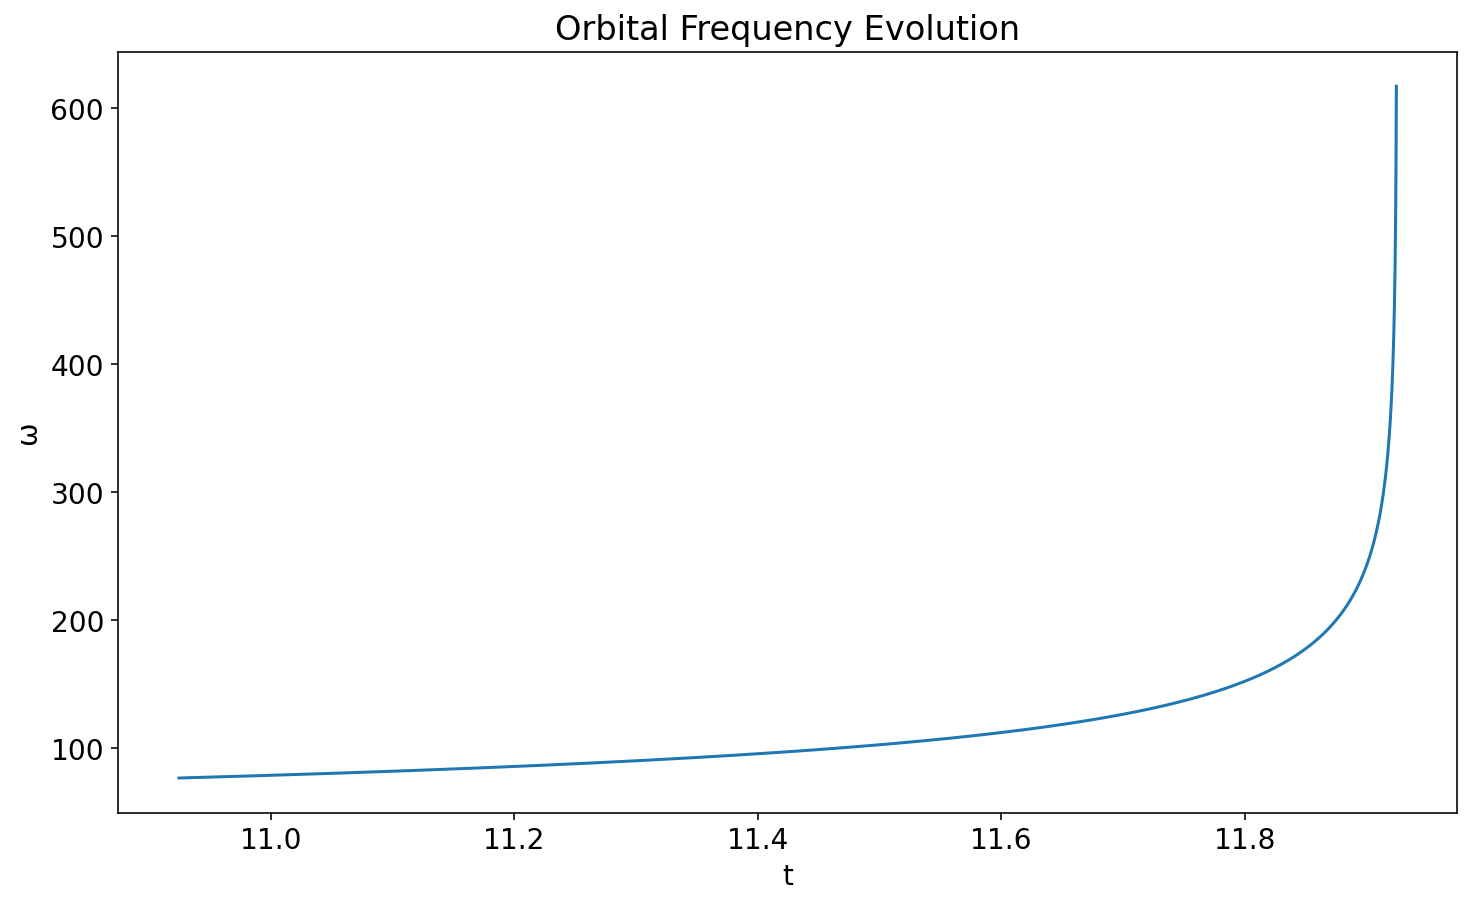

In [15]:
def ω(t):
    return(xins(t)**1.5/Ms) #Frequency derived by relationship of velocity to frequency


#This algorythm takes a function and maps it onto an array so that it can be plotted
ωs = makeGraphable(ω,tscaled,IntegrationSteps,label='ω')

plt.ylabel("ω")
plt.xlabel("t")            
plt.title('Orbital Frequency Evolution')

## Solving for Phase

Since by definition, an angular frequency is a change in phase in a given time, the phase evolution can be found by solving the following differential equation:

$$\frac{d\phi}{dt} = \omega$$

Just like with $x$, here we also have to convert the array returned by odeint into a function.

Text(0.5, 1.0, 'Phase Evolution')

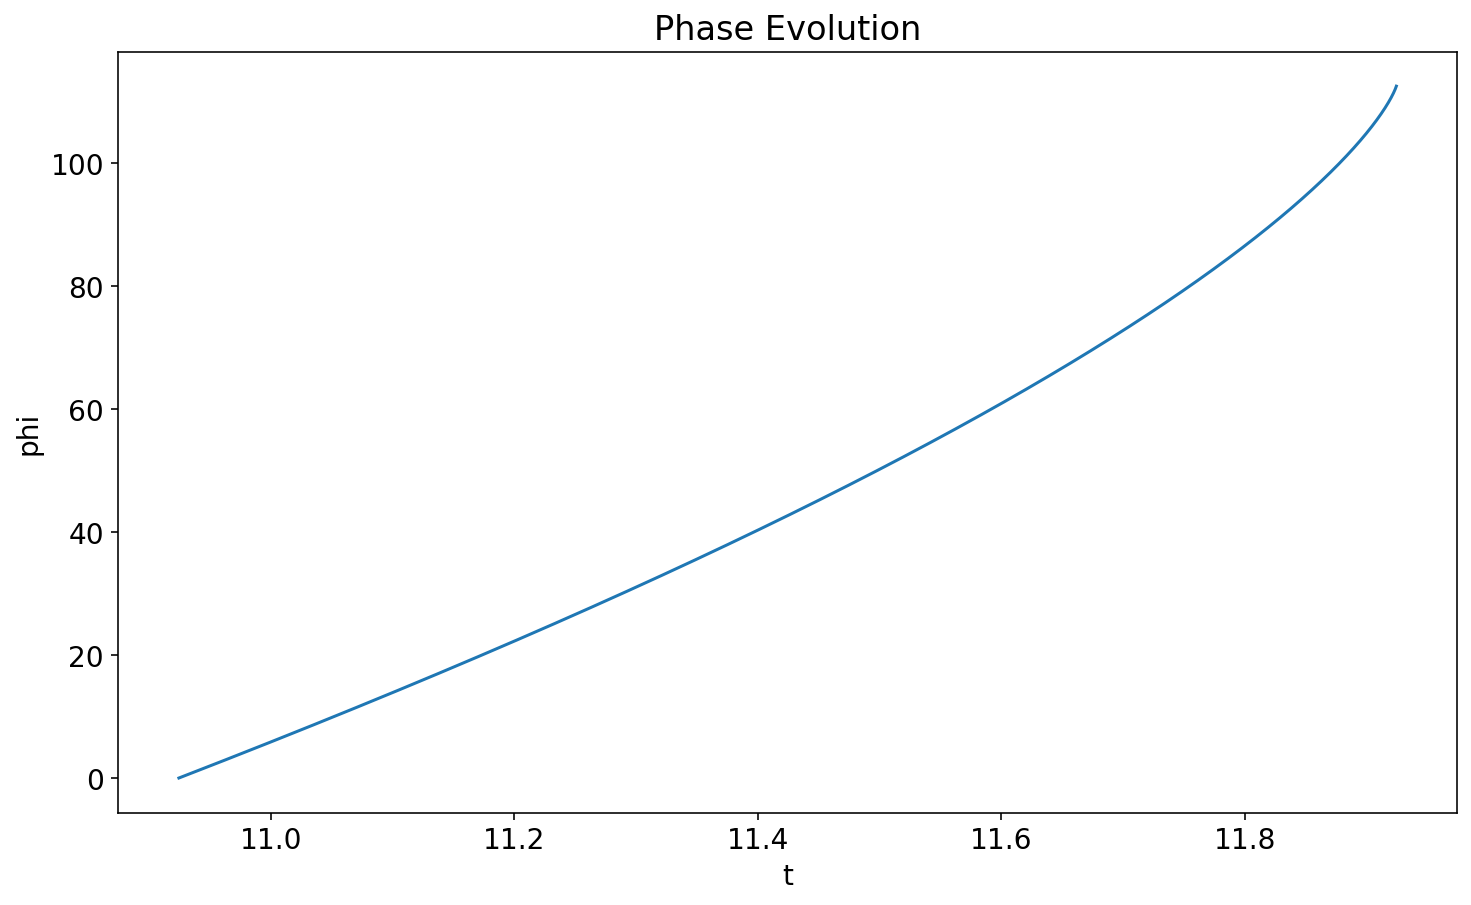

In [16]:
#Change in angle is equal over time is equal to angular frequency
def dΦ_dt(Φ, t):         
    return(ω(t))

#Solve the DE
phi0 = 0
solphi = odeint(dΦ_dt, phi0, tscaled)
solphi = np.array(solphi).flatten()# Plot the numerical solution
plt.rcParams.update({'font.size': 14})  # increase the font size



#This algorythm provides a map to turn the array of data points from the DE solution into a function of time.
def phiins(t):
    j = 0                                #i.e so that f(t) = x
    for i in tscaled:
        if tscaled[j] > t:
            return(solphi[j-1])
        if tscaled[j] == t:
            return(solphi[j])
        if t > tscaled[IntegrationSteps - 1]:
            return(solphi[IntegrationSteps - 1])
        j = j + 1
    return(t)

plt.xlabel("t")
plt.ylabel("phi")
plt.plot(tscaled, solphi,label='phi');
plt.title('Phase Evolution')

## Finding Separation of the Binary Objects

Additionally, since we found $x$, we can use Kepler's third law, $\omega^2r^3 = GM$, to solve for the distance between the binary black holes, $r$. Since we are trying to find $r$ with respect to time and are using geometric units, this equation can be simplified to:

$$r(t) = Mx(t)^{-1}$$

We can apply PN corrections to this equation resulting in (Hinder et al., 3):

$$r = M\big{(}r_{0PN}x^{-1} + r_{1PN} + r_{2PN}x + r_{3PN}x^2\big{)}$$

In [17]:
#Equations from Hinder et al. arxiv.org/pdf/0806.1037
#Coefficients from Memmesheimer et al. arxiv.org/pdf/gr-qc/0407049

#Different eccentricities can be used for this portion. If e = 0, all Cos terms cancel out
def Cos(u):
    return(math.cos(u)) 
def Sin(u):
    return(math.sin(u))
#default angle for ease of calculation
θ = pi/2

#coefficient r0
r0pn = (1 - e*Cos(θ))
print("r0pn = ",r0pn)

#coefficient r1
r1pn = ((2*(e*Cos(θ) - 1))/(e**2 - 1) + 1/6*(2*(η - 9) + e*(7*η - 6)*Cos(θ)))
print("r1pn = ",r1pn)

#coefficient r2
r2pn = (1/(1 - e**2)**2*(1/72*(8*η**2 + 30*η + 72)*e**4 + 1/72*(-16*η**2 - 876*η + 756)*e**2 + 1/72*(8*η**2 + 198*η + 360) + (1/72*(-35*η**2 + 231*η - 72)*e**5 + 1/72*(70*η**2 - 150*η - 468)*e**3 + 1/72*(-35*η**2 + 567*η - 648)*e)*Cos(θ) + (1 - e**2)**(1/2)*(1/72*(360 - 144*η)*e**2 + 1/72*(144*η - 360) + (1/72*(180 - 72*η)*e**3 + 1/72*(72*η - 180)*e)*Cos(θ))))
print("r2pn = ",r2pn)

#coefficient r3
r3pn = 1/(181440*(1 - e**2)**(7/2))*((-665280*η**2 + 1753920*η - 1814400)*e**6 + (725760*η**2 - 77490*pi**2*η + 5523840*η - 3628800)*e**4 + (544320*η**2 + 154980*pi**2*η - 14132160*η + 7257600)*e**2 - 604800*η**2 + 6854400*η + ((302400*η**2 - 1254960*η + 453600)*e**7 + (-1542240*η**2 - 38745*pi**2*η + 6980400*η - 453600)*e**5 + (2177280*η**2 + 77490*pi**2*η - 12373200*η + 4989600)*e**3 + (-937440*η**2 - 38745*pi**2*η + 6647760*η - 4989600)*e)*Cos(θ) + (1 - e**2)**(1/2)*((-4480*η**3 - 25200*η**2 + 22680*η - 120960)*e**6 + (13440*η**3 + 4404960*η**2 + 116235*pi**2*η - 12718296*η + 5261760)*e**4 + (-13440*η**3 + 2242800*η**2 + 348705*pi**2*η - 19225080*η + 16148160)*e**2 + 4480*η**3 + 45360*η**2 - 8600904*η + ((-6860*η**3 + 550620*η**2 - 986580*η + 120960)*e**7 + (20580*η**3 - 2458260*η**2 + 3458700*η - 2358720)*e**5 + (-20580*η**3 - 3539340*η**2 - 116235*pi**2*η + 20173860*η - 16148160)*e**3 + (6860*η**3 - 1220940*η**2 - 464940*pi**2*η + 17875620*η - 4717440)*e)*Cos(θ) + 116235*pi**2*η + 1814400) - 77490*pi**2*η - 1814400)
print("r3pn = ",r3pn)

r0pn =  1.0
r1pn =  -0.9166666666666665
r2pn =  1.1944444444444438
r3pn =  -2.0718780002752886


Text(0.5, 1.0, 'Radial Separation Evolution')

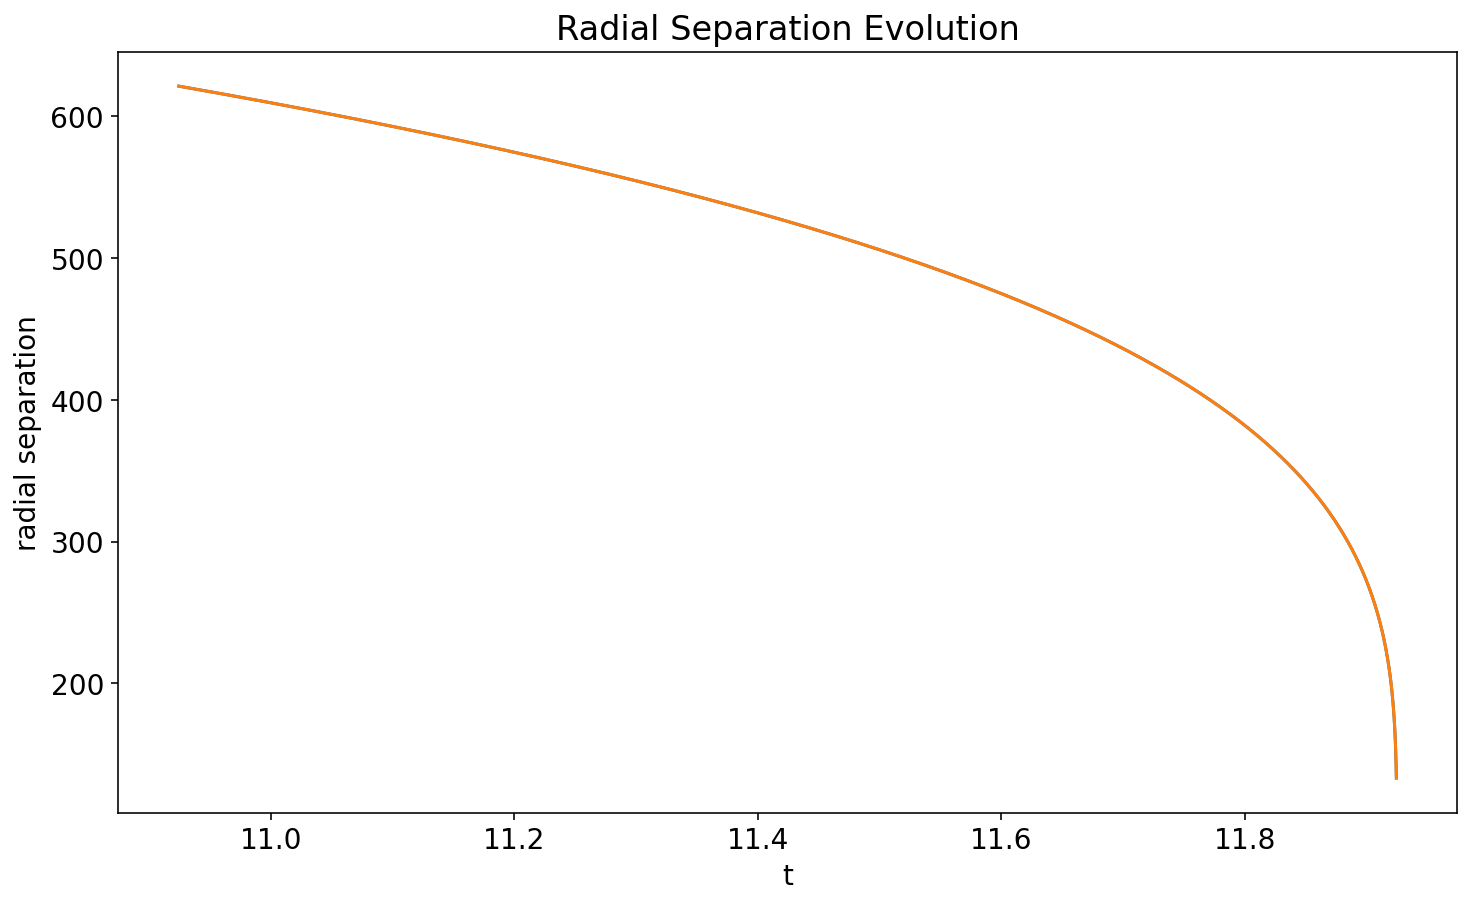

In [18]:
def radius(t):
    return(M * (r0pn * xins(t)**(-1) + r1pn + r2pn*xins(t) + r3pn * xins(t)**2))

#This algorithm takes a function and maps it onto an array so that it can be plotted
rs = makeGraphable(radius,tscaled,IntegrationSteps,label='r')

#Creating a function to return the derivative of the radius
def rdot(t):
    return(derivative(radius,t,dx = 6e-5)) #Derivative of radius wrt time
    
plt.ylabel("radial separation")
plt.xlabel("t")
plt.plot(tscaled, rs)
plt.title('Radial Separation Evolution')

## Calculation of Inspiral Waveform

Just like electromagnetic radiation, gravitational waves have two different polarizations. However, they differ in the angles between polarizations. Elecetromagnetic radiation's polarizations differ by $\pi/2$ while gravitational waves have polarizations the differ by $\pi/4$. These polarizations are $h_+$ and $h_\times$, representing plus-polarized and cross-polarized strains given by the general formula (Huerta et al., 4' Gopakumar and Iyer, 4):

$$h_+ = -\frac{M\eta}{r}\bigg{[}(\cos^2\theta+1)\bigg{[}\bigg{(}-\dot{r}^2+r^2\dot{\Phi}^2+\frac{M}{r}\bigg{)}\cos2\Phi+2r\dot{r}\dot{\Phi}\sin2\Phi\bigg{]}+\bigg{(}-\dot{r}^2+r^2\dot{\Phi}^2+\frac{M}{r}\bigg{)}\sin^2\theta\bigg{]}$$

$$h_\times = -2\frac{M\eta}{r}\cos\theta\bigg{[}\bigg{(}-\dot{r}^2+r^2\dot{\Phi}^2+\frac{M}{r}\bigg{)}\sin2\Phi-2r\dot{r}\dot{\Phi}\cos2\Phi\bigg{]}$$

These equations can be simplified by assuming the inclination angle, $\theta$ between the system and the observer is 0:

$$h_+ = -\frac{M\eta}{r}\bigg{[}\bigg{(}-\dot{r}^2+r^2\dot{\Phi}^2+\frac{M}{r}\bigg{)}\cos2\Phi+2r\dot{r}\dot{\Phi}\sin2\Phi\bigg{]}$$

$$h_\times = -2\frac{M\eta}{r}\bigg{[}\bigg{(}-\dot{r}^2+r^2\dot{\Phi}^2+\frac{M}{r}\bigg{)}\sin2\Phi-2r\dot{r}\dot{\Phi}\cos2\Phi\bigg{]}$$ 

The combined strain of the waveform can be found using (Huerta et al., 4):

$$h_{ins}(t) = h_+(t)-ih_\times(t)$$

This equation can be further simplified by using Euler's formula to change sines and cosines into their exponential forms:

$$h_{ins}(t) = A(t)e^{-2i\phi(t)}$$ 

$$A = A_1+iA_2$$

$$A_1 = -2\frac{M\eta}{r}\bigg{(}\dot{r}^2+r^2\dot{\Phi}^2+\frac{M}{r}\bigg{)}$$
$$A_2 = -2\frac{M\eta}{r}\bigg{(}2r\dot{r}\dot{\Phi}\bigg{)}$$

Text(0.5, 1.0, 'Amplitude Evolution')

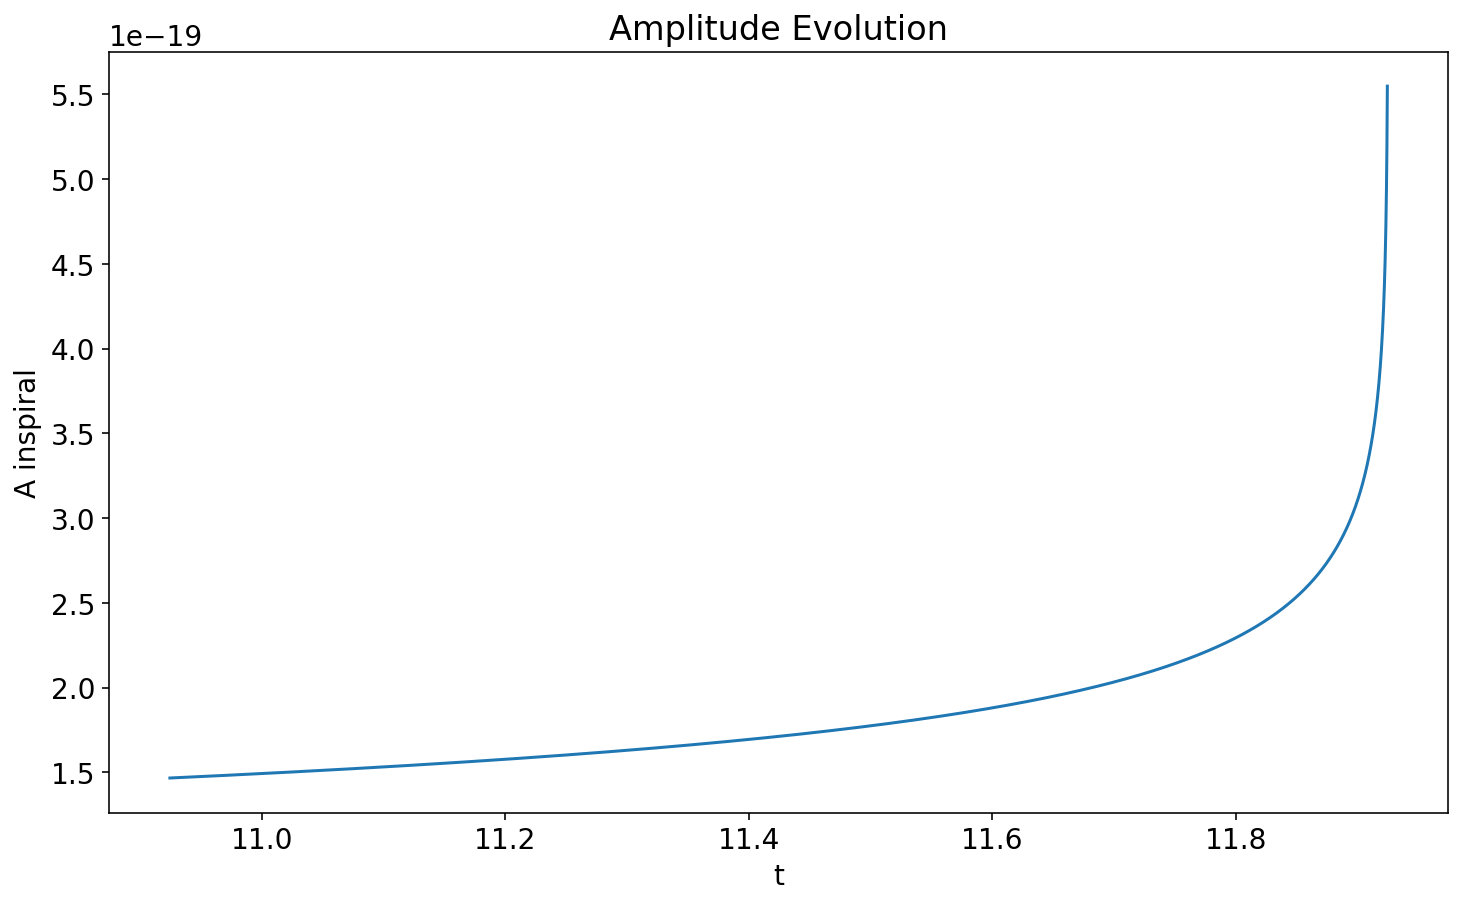

In [19]:
#plotting plus and cross polarization
#From Tiwari et al. arXiv:1511.09240

R = 2.401*10**19  #Distance to the binary (Andromeda)

#Plus polarized
def hpp(t):
    return(-((2*M*Mokm*η)/R)*((-(rdot(t)*Mos)**2 + (radius(t)*Mos)**2*ω(t)**2 + M/radius(t))*Cos(2*phiins(t)) + 2*radius(t)*rdot(t)*Mos**2*ω(t)*Sin(2*phiins(t))))

#Cross Polarized
def hcp(t):
    return(-((2*M*Mokm*η)/R)*((-(rdot(t)*Mos)**2 + (radius(t)*Mos)**2*ω(t)**2 + M/radius(t))*Sin(2*phiins(t)) - 2*radius(t)*rdot(t)*Mos**2*ω(t)*Cos(2*phiins(t))))

#Waveform Strain
def hins(t):
    return(hpp(t) - (hcp(t)*1j))

#This algorithm takes a function and maps it onto an array so that it can be plotted
hs = makeGraphable(hins,tscaled,IntegrationSteps,graph=False)

#Taking the absolute value of strain to get rid of oscillatory behavior
hgraphs = [0] * IntegrationSteps
n = 0
for x in hs:
    hgraphs[n] = abs(x)
    n = n + 1

plt.ylabel("A inspiral")
plt.xlabel("t")
plt.plot(tscaled, hgraphs,label='h')
plt.title('Amplitude Evolution')

By dividing the strain by the max amplitude, we can scale the graph so that its max value is at 1 to make it easier to observe. Notice how the plus-polarized strain lags behind the cross-polarized strain.

Ahins =  5.54802500309756e-19


Text(0.5, 1.0, 'Strain Evolution')

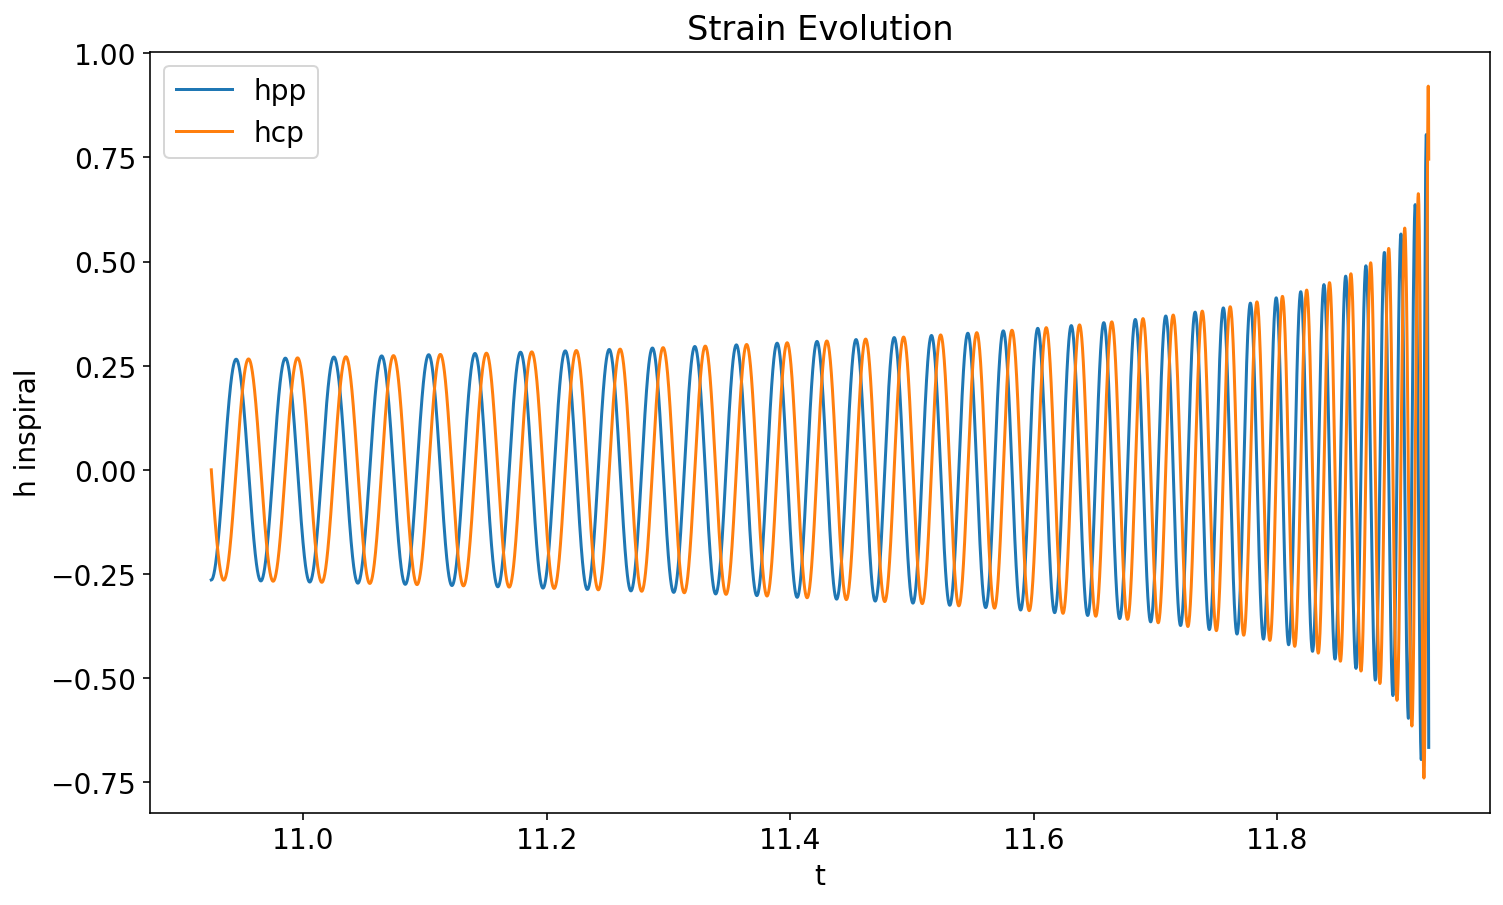

In [20]:
#Final Amplitude
Ahins = abs(hins(tFin))
print("Ahins = ",Ahins)

#An alternate array of hpps that divides by Ahins for the final graphs
hppgraph = makeGraphable(hpp,tscaled,IntegrationSteps,multiply=1/Ahins,label='hpp')

#An alternate array of hcps divided by Ahins to graph
hcpgraph = makeGraphable(hcp,tscaled,IntegrationSteps,multiply=1/Ahins,label='hcp')

plt.xlabel("t") 
plt.ylabel("h inspiral")
plt.legend()
plt.title('Strain Evolution')

The strain $h_{ins}$ calculated above is identical, after rescaling by a constant, to that generated by the dominant spin-weighted spherical harmonic $(l,m,s) = (2,2,-2)$, which gives a strain of, $h_{22}$ (Hinder et al., 4; Gopakumar and Iyer):

$$h_{22} = -4\frac{M\eta}{R}e^{-2i\Phi}\bigg{(}\frac{\pi}{5}\bigg{)}^{0.5}\bigg{(}(r\dot{\Phi}+i\dot{r})^2+\frac{M}{r}\bigg{)}$$

Text(0.5, 1.0, 'Spherical Harmonic Strain Evolution')

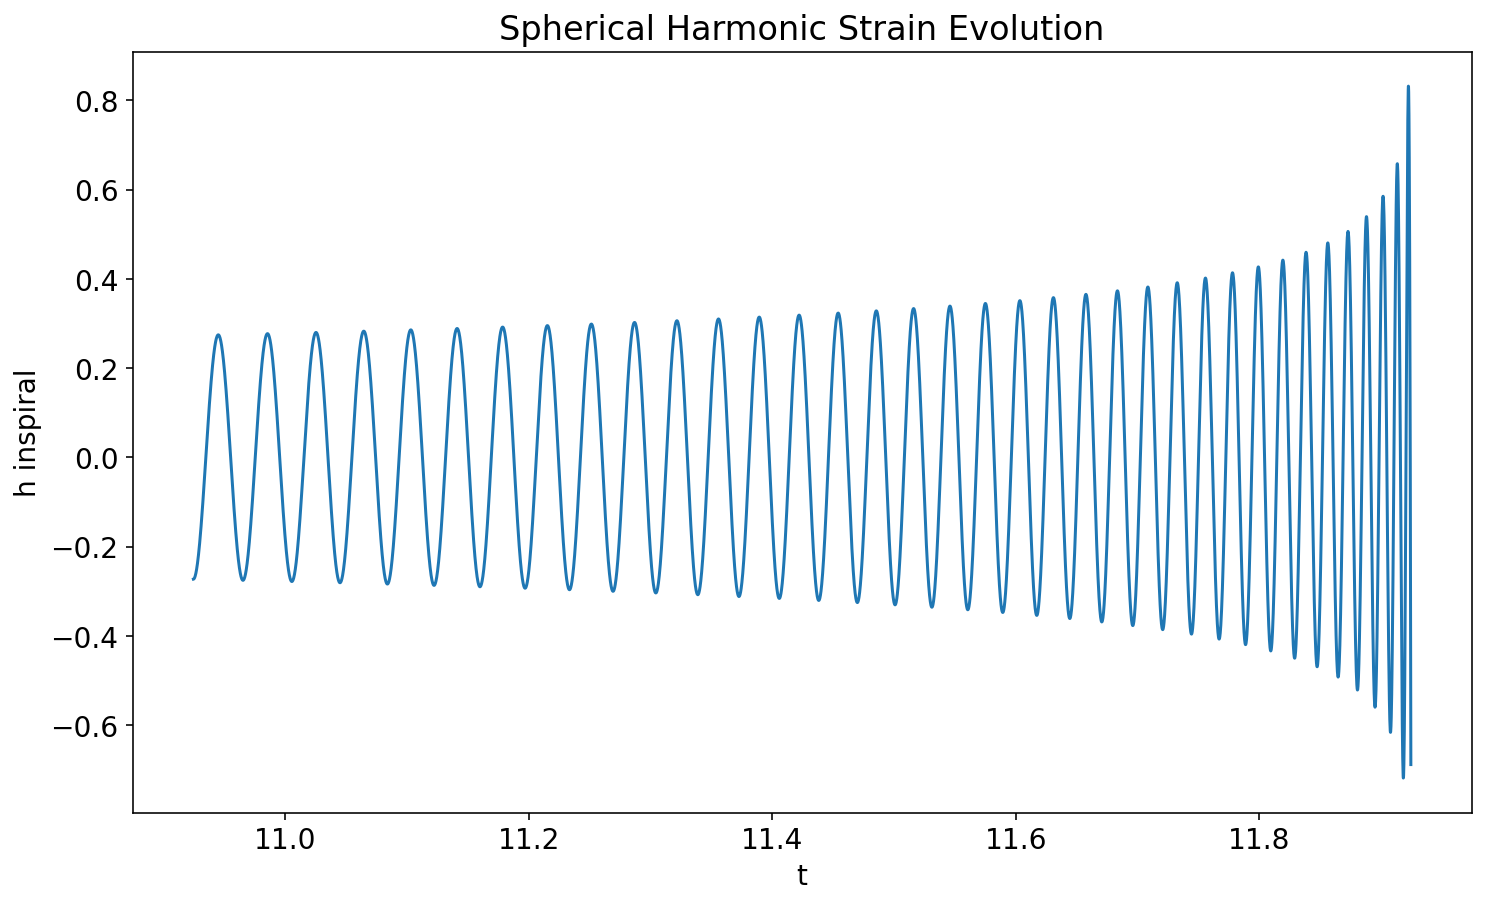

In [21]:
#Function of spherical harmonic component
def h22(t):
    return(-4*(M*Mokm*η)/R*exp(-2*1j*phiins(t))*(pi/5)**(1/2)*((((radius(t)*Mos*ω(t) + 1j*rdot(t)*Mos)**2) + M/radius(t))))


#Changes h22reals to the format needed for final graphs
h22graph = [0] * IntegrationSteps
j = 0
while j < IntegrationSteps:
    h22graph[j] = (((h22(tscaled[j])).real)/abs(h22(11.9244)))
    j = j + 1

plt.xlabel("t")
plt.ylabel("h inspiral")
plt.plot(tscaled, h22graph,label='h22')
plt.title('Spherical Harmonic Strain Evolution')

### Extra cell for data testing ###

In [22]:
#Test Data Here


# **Merger Ringdown Waveform**

## Functions and Coefficients

As mentioned previously, the PN model for gravitational waves becomes inaccurate when $v$ approaches $c$, so in order to model the merger phase, we have to resort to previously determined analytical techniques. We will be using the $\textit{generic Implicit Rotating Source, gIRS}$ model due to its compatability with numerical relativity, accuracy, and simplicity. The process for this is fairly streamlined. We begin with the equation for strain:

$$h_{merger} = A(t)e^{i\Phi_{gIRS}(t)}$$

where $A$ is equal to (East et al., 6):

$$A(t) = \frac{A_0}{\omega(t)}\bigg{[}\frac{\mid\hat{f}\mid}{1+\alpha\big{(}\hat{f}^2-\hat{f}^4\big{)}}\bigg{]}^{1/2}$$

Notice how in order to find amplitude, frequency, $\hat{f}$, and angular orbital velocity, $\omega$ must be found. Both of these have been determined analytically (East et al., 6):

$$\hat{f} = \frac{c}{2}\bigg{(}1+\frac{1}{\kappa}\bigg{)}^{1+\kappa}\bigg{[}1-\big{(}1+\frac{1}{\kappa}e^{-2t/b}\big{)}^{-\kappa}\bigg{]}$$

$$\omega(t) = \omega_{QNM}\big{(}1-\hat{f}\big{)}$$

where $\omega_{QNM}$ is the least damped frequency of the quasi-normal modes given by (Huerta et al., 7):

$$\omega_{QNM} = 1-0.63\big{(}1-\hat{s}\big{)}^{0.3}$$

where $\hat{s}_{fin}$ is the final spin of the black hole given by (Huerta et al., 7):

$$\hat{s}_{fin} = 2\sqrt{3}\eta-\frac{390}{79}\eta^2+\frac{2379}{287}\eta^3-\frac{4621}{276}\eta^4$$

By using analytically determined functions of the symmetric mass ratio, $\eta$, we are able to find the frequency and angular orbital velocity.

In [23]:
# gIRS Coefficients from Huerta et al. (Eq. 24-29) arxiv.org/pdf/1609.05933

sfn = 2*(3)**(1/2)*η - 390/79*η**2 + 2379/287*η**3 - 4621/276*η**4 #final spin
print("sfn = ",sfn)

ωqm = 1 - (0.63*(1-sfn)**(0.3)) #least damped frequency of the quasi-normal mode
print("ωqm = ",ωqm)

b = 16014/979 - 29132/1343*η**2
print("b = ",b)

c = 206/903 + 180/1141*η**(1/2) + 424/1205*η**2/math.log(η) #b,c and k are parameters found from simulations by Huerta et al.
print("c = ",c)

k = 713/1056 - 23/193*η
print("k = ",k)

Q = 2/(1 - sfn)**0.45 #quality factor
print("Q = ",Q)

b2 = 2*Q/ωqm
print("b2 = ",b2)

α = (1/Q**2)*(16313/562 + 21345/124*η) #extra parameter
print("α = ",α)

α2 = 72.3/Q**2
print("α2 = ",α2)

sfn =  0.621598446869387
ωqm =  0.5293192654626497
b =  15.001774228264896
c =  0.2911429785609846
k =  0.6453966478254043
Q =  3.097071174133577
b2 =  11.702091256499392
α =  7.51272858254152
α2 =  7.53764926192454


In [24]:
#Time in geometric units in terms of binary mass
def times(t):
    return(t/(M*Mos))

#Linear frequency
def fs(t):
    return((c/2*((1 + 1/k)**(1 + k)))*(1 - (1 + (1/k)*exp((-2*times(t))/b))**(-k)))

# f^2
def fs2(t):
    return(fs(t)**2)

#f^4
def fs4(t):
    return(fs2(t)**2)

#df/dt
def fsdot(t):
    return(derivative(fs, t, dx = 1e-6))


# Orbital Frequency Evolution

Here, we solve for orbital frequency as described above, but we also introduce the timescale used for the rest of the merger.

Text(0.5, 1.0, 'Merger Orbital Frequency Evolution')

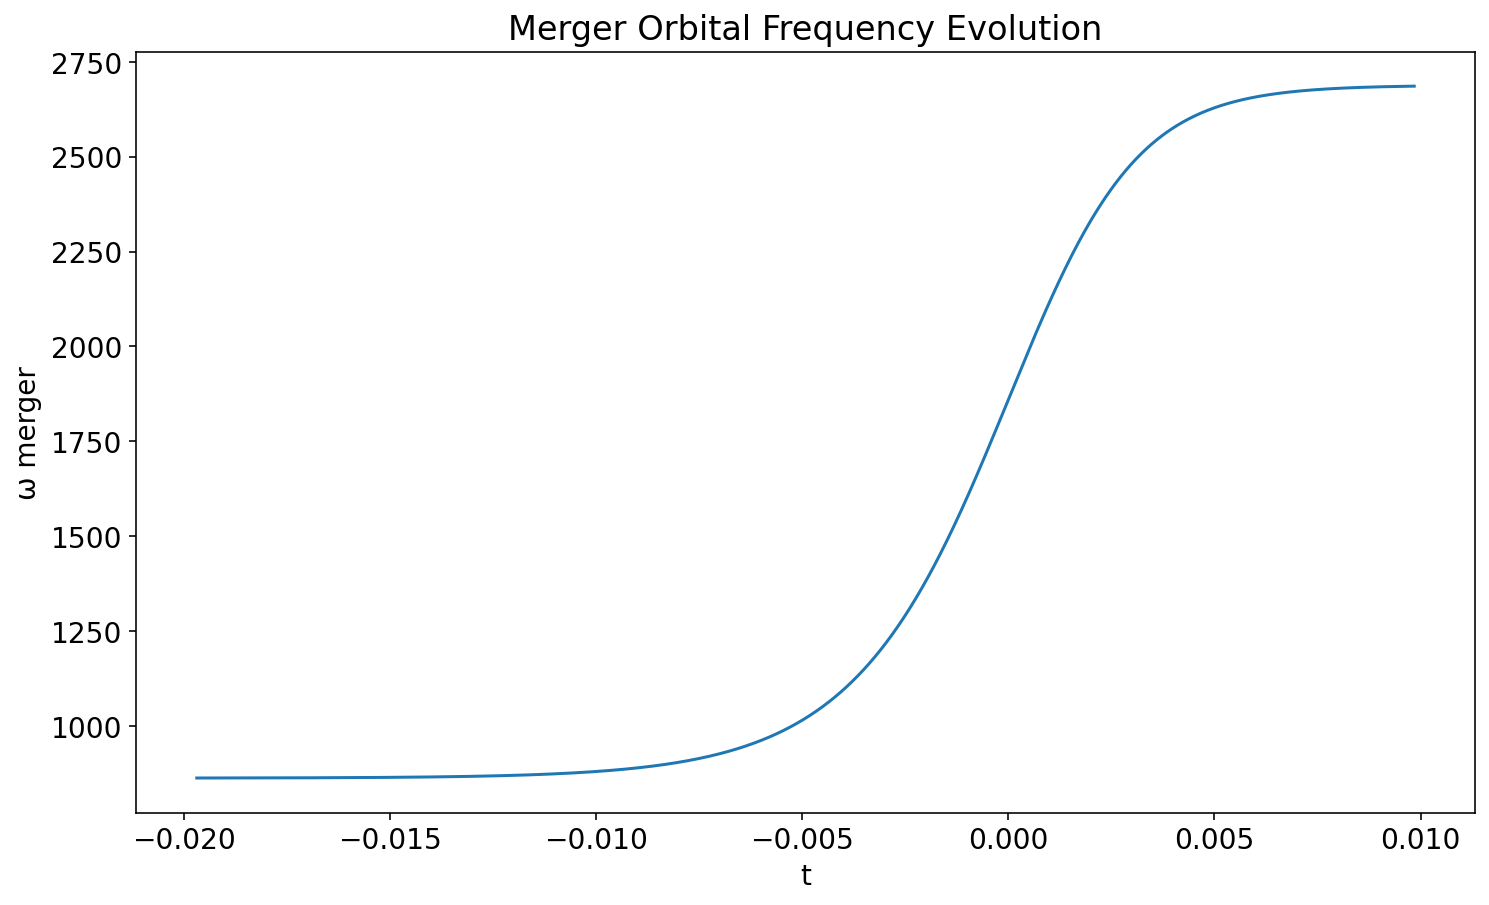

In [25]:
#Angular Frequency
def omega(t):
    return((ωqm/(M*Mos))*(1 - fs(t)))

#minimum and maximum times
tmin = -100
tmax = 50

#min and max times in units of binary mass
tsmin = tmin*M*Mos
tsmax = tmax*M*Mos

#Breaks the time axis into 1000 points between ti and tf
scale = 10000
tsmerger = linspace(tsmin,tsmax,scale)

#Changes omega to a graphable array
makeGraphable(omega,tsmerger,scale,label='ω')

plt.ylabel("ω merger")
plt.xlabel("t")    
plt.title('Merger Orbital Frequency Evolution')

After finding the orbital frequency evolution, we can immediately calculate the phase evolution by integrating:

$$\Phi_{gIRS}(t) = \int\omega(t)dt$$

Since we do not yet know the time where the merger takes place, we use an indefinite integral. To integrate, since sympy was unable to correctly calculate the integral, we used Mathematica to determine what the antiderivative looks like and then solved it in python.

Text(0.5, 1.0, 'Merger Phase Evolution')

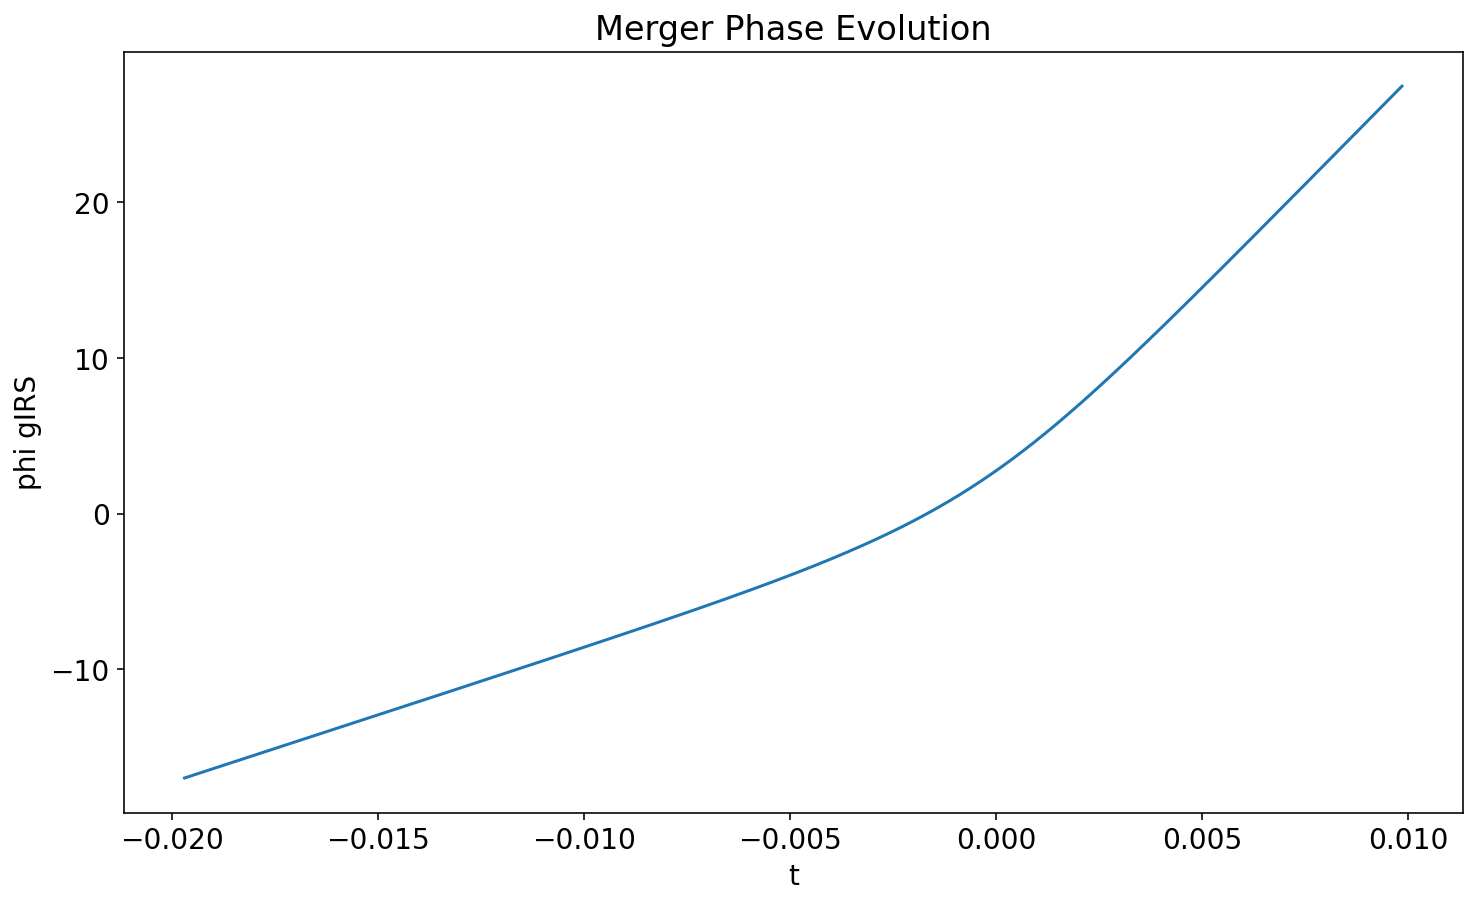

In [26]:
#Antiderivative of omega found using Mathematica
def antiderivOmega(t,k,c,b):
    a = ωqm/(M*Mos)
    d = (c/2*((1 + 1/k)**(1 + k)))
    f = 1/k
    g = (-2*(1/(M*Mos)))/b
    cons = a-a*d
    A = a*d
    h = hyp2f1(k,k,k+1,-exp(-g*t)/f)
    return((cons*t - (((A * (((f+exp(-g*t))/f)**k) * ((f*exp(g*t)+1)**-k) * h))/(g*k))))

#phi - equal to integral of omega
def phimerges(t):
    return(antiderivOmega(t,k,c,b))

#Changes phi to a graphable array
phimerge = makeGraphable(phimerges,tsmerger,scale,label='phi')

plt.ylabel("phi gIRS")
plt.xlabel("t")
plt.title('Merger Phase Evolution')

Now that we have all of the pieces, we can calculate the amplitude and subsequently the strain as described above. Notice how the imaginary portion of strain lags behind the real portion.

Text(0.5, 1.0, 'Merger Amplitude')

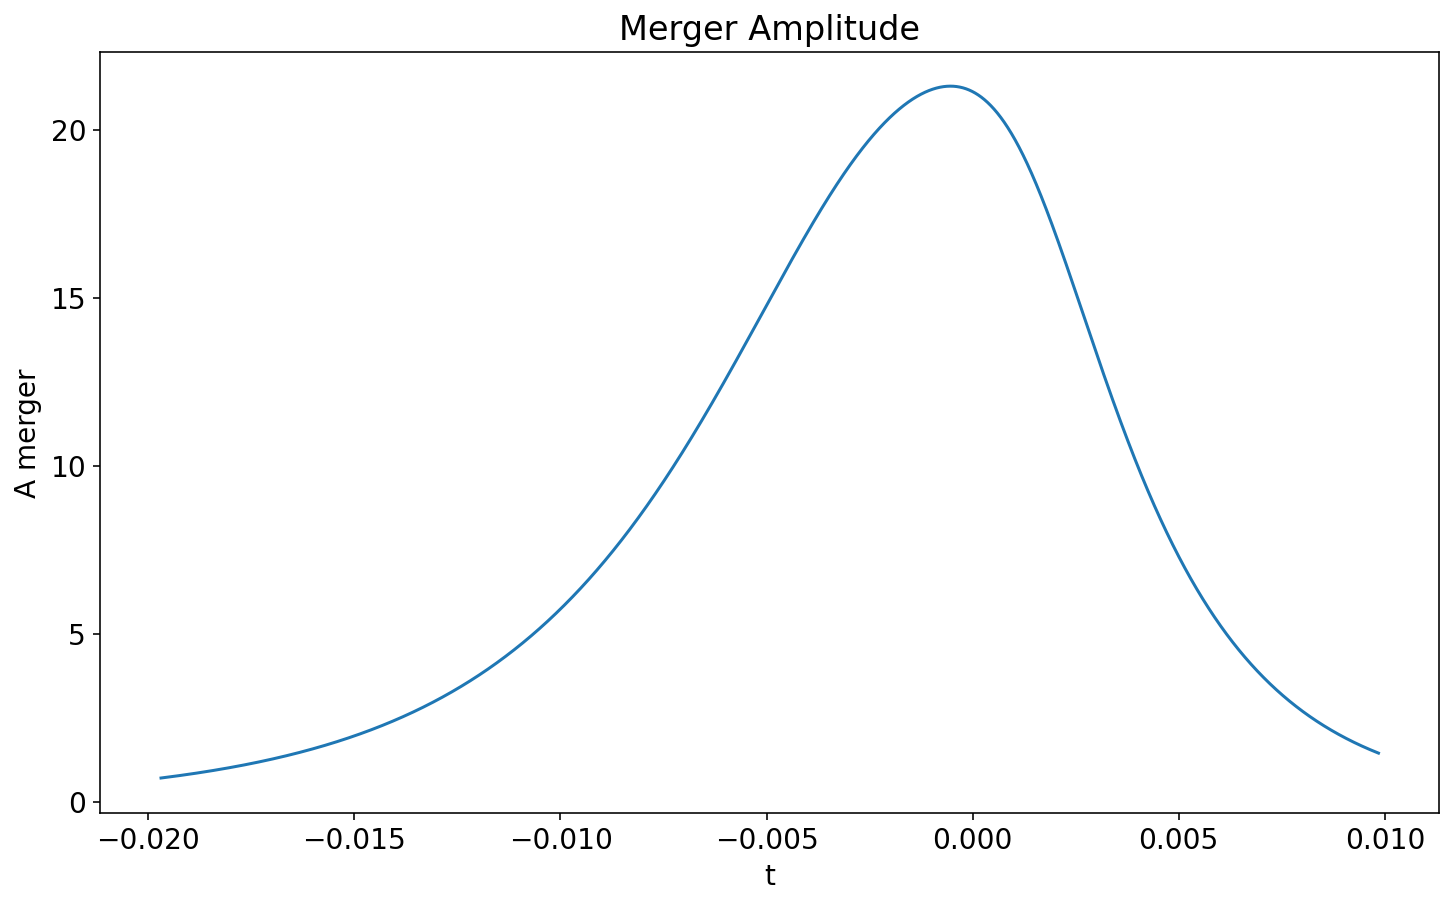

In [27]:
#Formula for amplitude from East et al. arxiv.org/pdf/1212.0837 Eq. 8

#Initial amplitude
A0 = 1/(M*Mos)

#Amplitude as a function of time
def As(t):
    return((A0/omega(t))*((abs(fsdot(t)))/(1 + α*(fs2(t) - fs4(t))))**(1/2))

#Changes amplitude as a function of time to a graphable array
Amps = makeGraphable(As,tsmerger,scale,label='A')

plt.ylabel("A merger")
plt.xlabel("t")
plt.title("Merger Amplitude")


If we divide the strain by the maximum amplitude, we can graph the strain as a ratio so that it can be matched with the strain from the inspiral phase.

In [28]:
# Max Amplitude
max = np.max(Amps)

In [29]:
#strain of merger
def hmerg(t):
    return((As(t)*exp(-phimerges(t) * 1j )).real)
def hmergimag(t):
    return((As(t)*exp(-phimerges(t) * 1j )).imag)

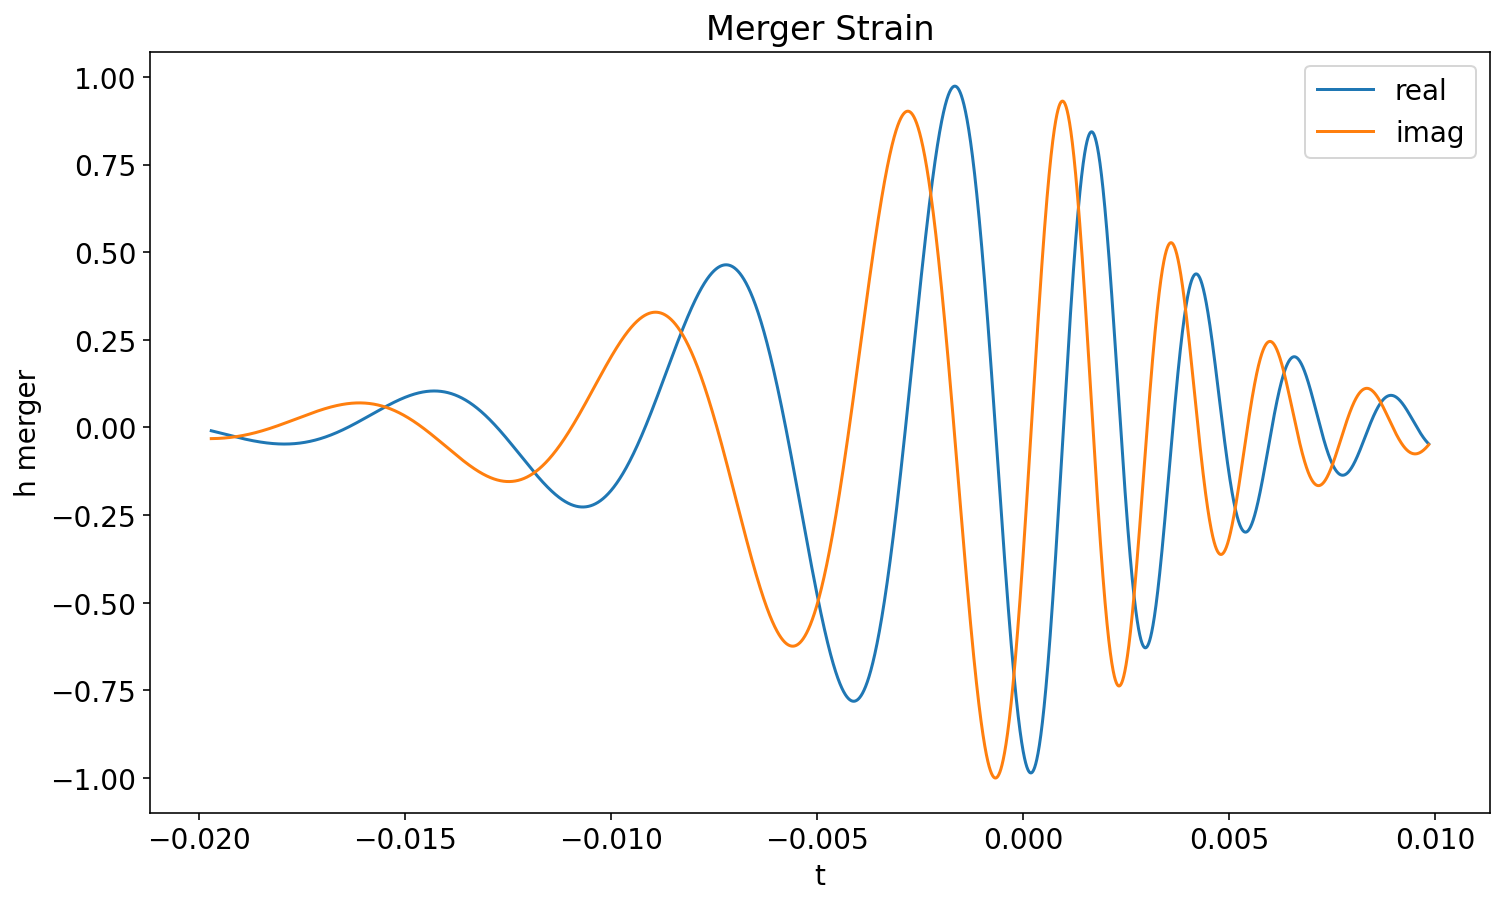

In [30]:
#Re-mapping function as an array
hmerges = makeGraphable(hmerg,tsmerger,scale,multiply=1/max,label='real')

#Re-mapping imaginary portion of function as array
hmergesimag = makeGraphable(hmergimag,tsmerger,scale,multiply=1/max,label='imag')

plt.ylabel("h merger")
plt.xlabel("t")
plt.title("Merger Strain")
plt.legend()

In [31]:
#Linear frequencies of merger and inspiral

def fmerger(t):
    return(omega(t)/(2*pi))

def fins(t):
    return(ω(t)/pi)

#Innermost stable circular orbit 
fISCO = (1/(pi*M*Mos)*(1/6)**(3/2))

# Overlapping the Models

In order to match the inspiral waveform with the merger waveform, we first need to set the two graphs onto the same timescale. To do this, we first shift the inspiral so that it ends at $t=0$. The matching technique we use is based off of one utilized by Buskirk and Babiuc in $\textit{A Complete Analytic Gravitational Wave Model for Undergraduates}$.

In [32]:
#Time array that shifts the inspiral to the same time the merger is
tmatch = modifyArray(tscaled,IntegrationSteps,add=-tFin)

#Changes the linear frequencies of merger and inspiral phases to graphable arrays
fmergraph = makeGraphable(fmerger,tsmerger,scale,graph=False)

finsgraph = makeGraphable(fins,tscaled,IntegrationSteps,graph=False)


To make the matching easier to see and analyze, we zoom in on the portion of the inspiral that occurs during the merger time-frame.

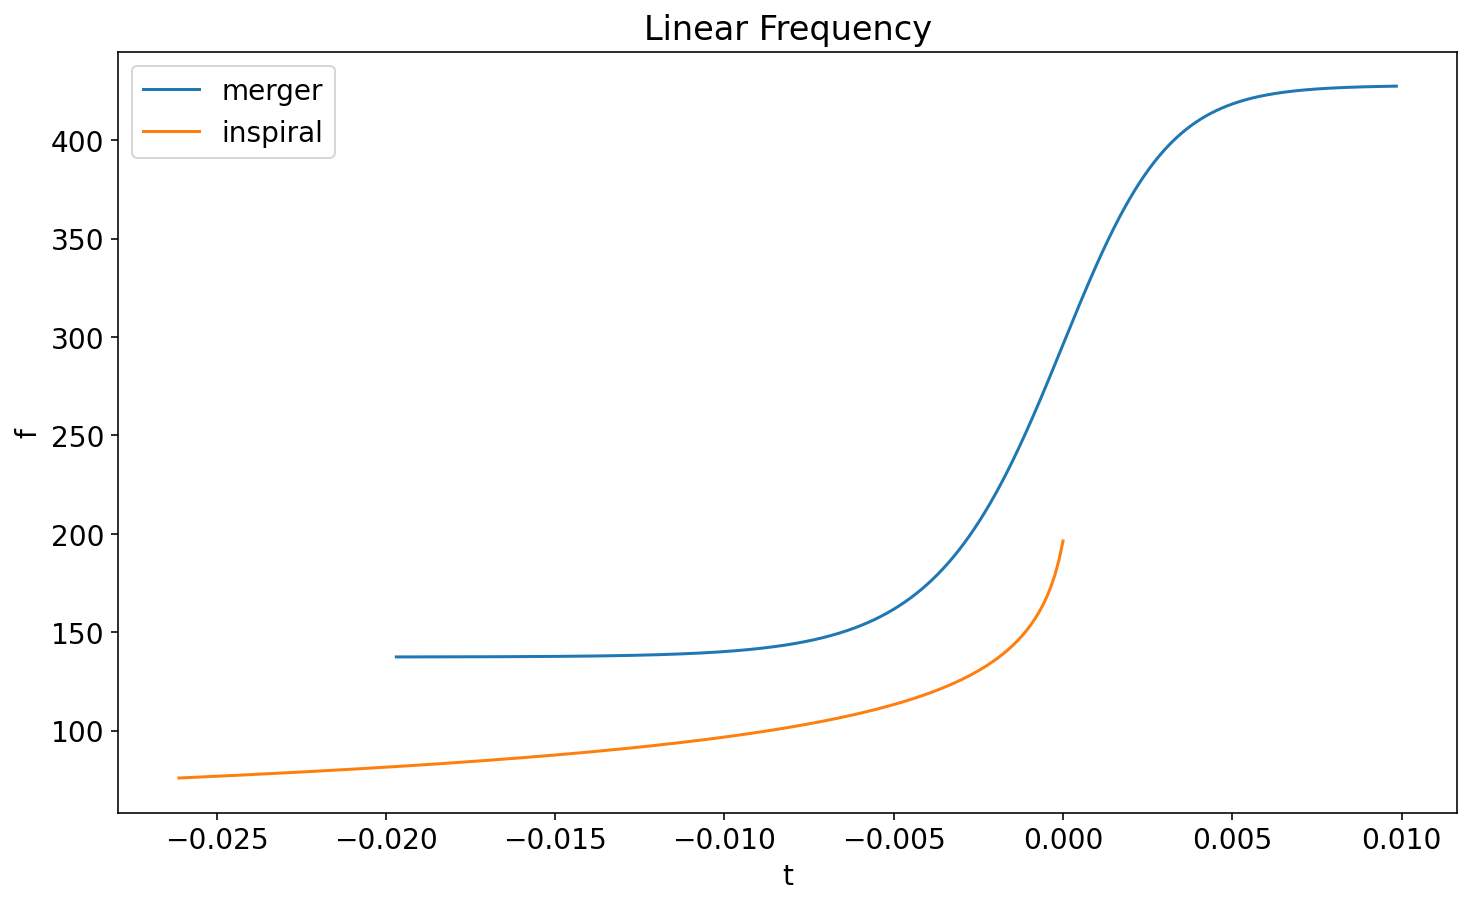

In [33]:
#Lower bound for the inspiral so that it can be accurately matched to the merger

lb = 8167 #This number doesn't exactly matter. It is used to effectively zoom in to where the matching happens
finsmatch = finsgraph[lb:]
tmatched = tmatch[lb:]

plt.ylabel("f")
plt.xlabel("t")
plt.plot(tsmerger, fmergraph, label = 'merger')
plt.plot(tmatched, finsmatch, label = 'inspiral')
plt.title("Linear Frequency")
plt.legend()


Next, we determine the amount of time that the merger needs to be shifted to match with the inspiral, $\tau$. To do this, we calculate the time on the merger where the linear frequency is equal to the final linear frequency of the inspiral. The merger needs to be shifted so that point lies at $t=0$ with the inspiral.

In [34]:
#Time the merger needs to be shifted by to match the inspiral
arraySize = IntegrationSteps - lb 
n = 0
for i in fmergraph:
    if i > finsmatch[arraySize - 1]:
        τ = 0 - tsmerger[n]
        print("τ =",τ)
        break
    n = n + 1

τ = 0.002868426642664266


After determining $\tau$, we shift the merger by $\tau$ and graph the resulting match.

τ = 0.002868426642664266


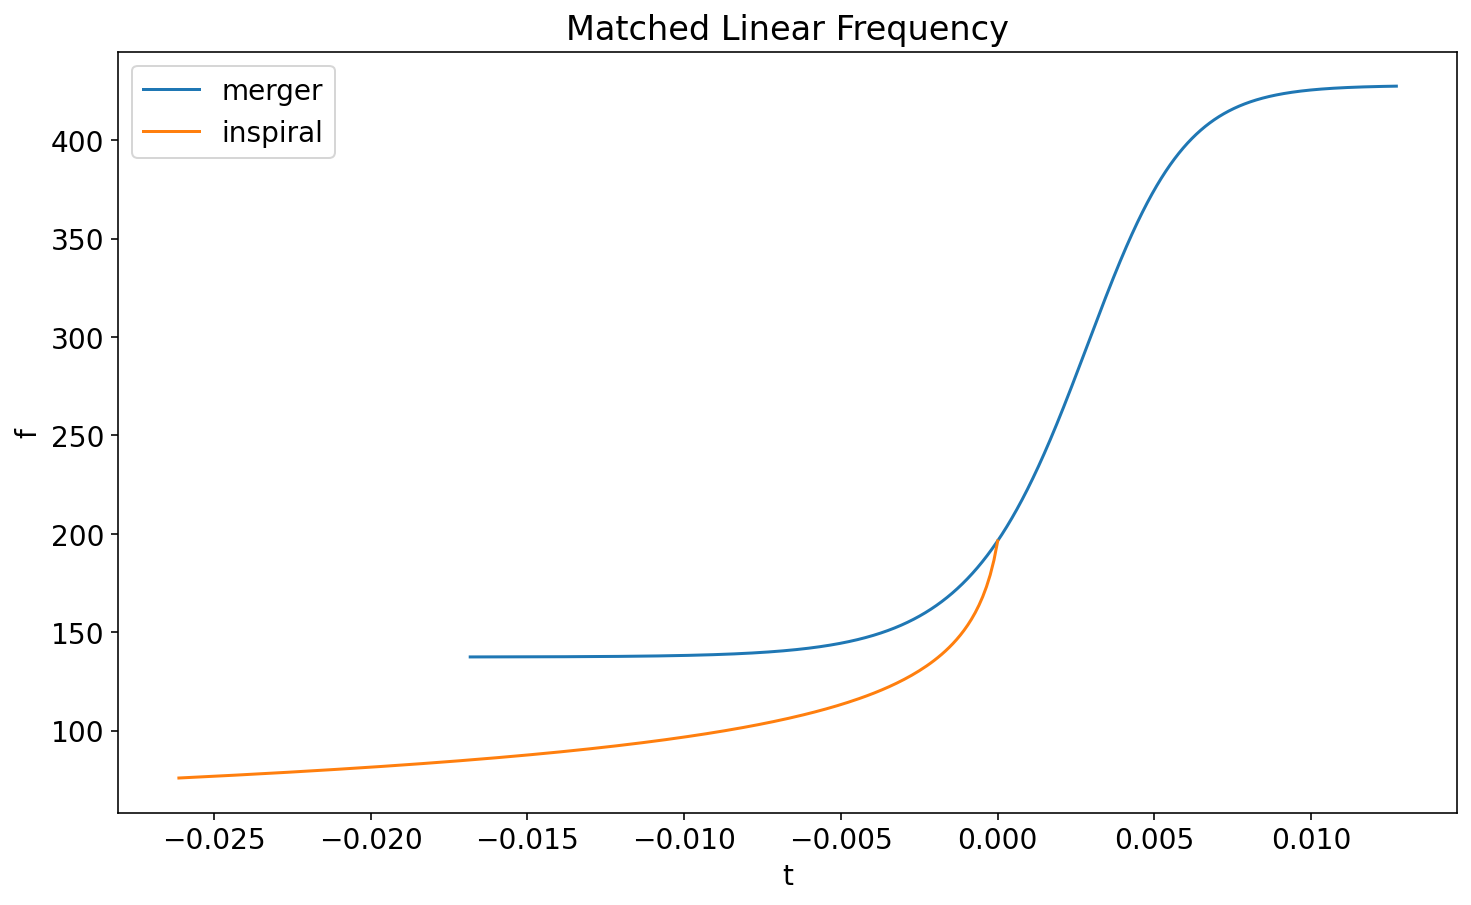

In [35]:
#Changes merger time array to shift for matching
tsadjusted = modifyArray(tsmerger,scale,add=τ)

plt.ylabel("f")
plt.xlabel("t")
plt.plot(tsadjusted, fmergraph, label="merger")
plt.plot(tmatched, finsmatch, label='inspiral')
plt.title('Matched Linear Frequency')
plt.legend()

print("τ =",τ)

After matching the linear frequency and determining $\tau$ we can now match the real and imaginary portions of the strain for the inspiral and merger phases. We do this by adjusting the time-frame of the merger by adding $\tau\xi$ to the merger's time axis. Adjust $\xi$ until the fit of the merger and inspiral seems to be the best fit.

In [36]:
#Inverts the real portion of merger strain for matching
hmergesmatch = modifyArray(hmerges,scale,multiply=-1)

In [1]:
#Inspiral real strain fixed to merger timescale
hppadjusted = makeGraphable(hpp,tscaled,IntegrationSteps,multiply=1/Ahins,graph=False)  
hppmatch = hppadjusted[lb:]

#Inspiral imaginary strain fixed to merger timescale
hcpadjusted = makeGraphable(hcp,tscaled,IntegrationSteps,multiply=1/Ahins,graph=False)
hcpmatch = hcpadjusted[lb:]

#Graphing the real portions of the strain for merger and inspiral
plt.xlabel('t')
plt.ylabel('h')
plt.plot(tsmerger, hmergesmatch, label='merger')
plt.plot(tmatched, hppmatch, label='inspiral')
plt.title("Real Portion of Strain")
plt.legend()

NameError: name 'makeGraphable' is not defined

In [0]:
n=0
trRe = 0
for i in hmergesmatch:
    n = n + 1
    if i < hppmatch[arraySize - 1]:
        trRe = tsmerger[n]
        break
        
print("trRe=",trRe)

tstrainmatchre = modifyArray(tsmerger,scale,multiply=1,add=-trRe)

plt.plot(tstrainmatchre, hmergesmatch, label='merger')
plt.plot(tmatched, hppmatch, label='inspiral')
plt.legend()

In [0]:
ξ = 0.80

tdifference = τ*ξ

tstrainmatchre1 = modifyArray(tsmerger,scale,add=tdifference)

plt.xlabel('t')
plt.ylabel('h')
plt.plot(tstrainmatchre1, hmergesmatch, label='merger')
plt.plot(tmatched, hppmatch, label='inspiral')
plt.title("Matched Real Portion of Strain")
plt.legend()

In [0]:
#Plotting imaginary portions of merger and inspiral strain
plt.xlabel('t')
plt.ylabel('h')
plt.title('Imaginary Portion of Strain')
plt.plot(tsmerger, hmergesimag, label='merger')
plt.plot(tmatched, hcpmatch, label='inspiral')
plt.legend()

In [0]:
n=0
trImag = 0
for i in hmergesimag:
    n = n + 1
    if i < hcpmatch[arraySize-1]:
        if (hmergesimag[n-2] > hcpmatch[arraySize-1]):
            trImag = tsmerger[n]
            break
            
print("trImag =",trImag)

tstrainmatch = modifyArray(tsmerger,scale,multiply=1,add=-trImag)

plt.plot(tstrainmatch, hmergesimag, label='merger')
plt.plot(tmatched, hcpmatch, label='inspiral')

In [0]:
ξ = 0.82

tdifferenceimag = τ*ξ

tstrainmatch1 = modifyArray(tsmerger,scale,add=tdifferenceimag)

plt.xlabel('t')
plt.ylabel('h')
plt.plot(tstrainmatch1, hmergesimag, label='merger')
plt.plot(tmatched, hcpmatch, label='inspiral')
plt.title("Matched Imaginary Portion of Strain")
plt.legend()

## Making the Full Waveform

To make the full waveform, we take the strain for the inspiral phase and graph it in its entirety and add the strain of the merger phase from $t=0$ to its completion. To determine the total time of the waveform, we take the time for the inspiral phase $11.9244$ seconds and add the final time from the merger since we graphed it from $t=0$ to $t=t_{fin}$. However, since we shifted the merger to match the inspiral, we must also add the time the merger was shifted.

In [0]:
#Finding at what array index the inspiral stops - where the merger begins
n = 0
for t in tstrainmatchre:
    n = n + 1
    if t > 0:
        break;

#Shifting the merger to begin where needed
tfullre = tstrainmatchre[(n):]
hrealfull = hmergesmatch[(n):]

plt.xlabel('t')
plt.ylabel('h')
plt.plot(tfullre, hrealfull, label='merger gIRS')
plt.plot(tmatched, hppmatch, label='inspiral PN')
plt.title("Full Real Waveform")
plt.legend()

In [0]:
#Finding at what array index the inspiral stops - where the merger begins
n = 0
for t in tstrainmatch:
    n = n + 1
    if t > 0:
        break;

#Shifting the merger to begin where needed
tfull = tstrainmatch[(n):]
himagfull = hmergesimag[(n):]

plt.xlabel('t')
plt.ylabel('h')
plt.title('Full Imaginary Waveform')
plt.plot(tfull, himagfull, label='merger gIRS')
plt.plot(tmatched, hcpmatch, label='inspiral PN')
plt.legend()

## Bibliography

Buskirk and Babiuc, A Complete Analytic Gravitational Wave Model for Undergraduates, https://arxiv.org/pdf/1810.06160.pdf \
Huerta et al., Complete waveform model for compact binaries on eccentric orbits, https://arxiv.org/pdf/1609.05933.pdf \
Hinder et al., Comparisons of eccentric binary black hole simulations with post-Newtonian models, https://arxiv.org/pdf/0806.1037.pdf \
East et al., Observing complete gravitational wave signals from dynamical capture binaries, https://arxiv.org/pdf/1212.0837.pdf \
Blanchet, Gravitational Radiation from Post-Newtonian Sources and Inspiralling Compact Binaries, https://arxiv.org/pdf/1310.1528.pdf \
Tiwari et al., A Proposed Search for the Detection of Gravitational Waves from Eccentric Binary Black Hole, https://arxiv.org/pdf/1511.09240.pdf \
Gopakumar and Iyer, Second post-Newtonian gravitational wave polarizations for compact binaries in elliptical orbits, https://arxiv.org/pdf/gr-qc/0110100.pdf \
Memmesheimer et al., Third post-Newtonian accurate generalized quasi-Keplerian
parametrization for compact binaries in eccentric orbits, https://arxiv.org/pdf/gr-qc/0407049.pdf
